In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy import signal
from scipy import interpolate as interp
import scipy.ndimage
import matplotlib.pylab as pl
import time
import cv2 as cv
import ot
import math

In [2]:
def SW_gradSW(u,v,Teta):#Pour deux images de même taille 
    N = u.shape[0]
    M = u.shape[1]
    d = u.shape[2]
    
    nbProj = Teta.shape[0]
    
    SW = 0
    gradSW = np.zeros((N,M,d))
    
    for i in range(nbProj):
        uteta = np.zeros(N*M)
        vteta = np.zeros(N*M)
        for j in range(N*M):#np.int(np.floor(i/M)), np.int(i - np.floor(i/M)*M)
            uteta[j] = np.dot(u[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
            vteta[j] = np.dot(v[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)], Teta[i])
        u_sorted = np.sort(uteta)
        v_sorted = np.sort(vteta)
        Iu_sorted = np.argsort(uteta)
        Iv_sorted = np.argsort(vteta)
        SW = SW + np.sum((u_sorted - v_sorted)**2)
        sigma = np.zeros(N*M)
        sigma[Iu_sorted] = Iv_sorted
        
        for j in range(N*M):
                gradSW[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] = gradSW[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] + np.dot(u[np.int(np.floor(j/M)), np.int(j - np.floor(j/M)*M)] - v[np.int(np.floor(sigma[j]/M)), np.int(sigma[j] - np.floor(sigma[j]/M)*M)], Teta[i])*Teta[i]
        
    SW = SW/nbProj
    
    return SW, gradSW

In [3]:
def spectrale_degradation(img, b_low, b_high, adjoint):
    if(adjoint == 0):
        d = img.shape[2]
        out = np.zeros((img.shape[0], img.shape[1], b_low))
        for i in range(b_low):
            for j in range(d):
                out[:,:,i] = out[:,:,i] + img[:,:,j]
            
            out[:,:,i] = out[:,:,i]/d
        return out
    else :
        d = img.shape[2]
        out = np.zeros((img.shape[0], img.shape[1], b_high))
        for i in range(b_high):
            out[:,:,i] = 1/3*img[:,:,0]
        return out 
    
def spatial_degradation(img,K,adjoint):
    sx , sy, d = img.shape[0], img.shape[1], img.shape[2]
    GaussBlur = cv.getGaussianKernel(5,5)
    GaussBlur_adj = GaussBlur.transpose()
        
    if adjoint==0: #Blur de l'image + sous-echantillonnage 
        imgBlurred = cv.filter2D(img, -1, GaussBlur)#Blur de l'image
        #Sous-echantillonnage
        Sx = math.floor(sx/K)
        Sy = math.floor(sy/K)
        out = np.zeros([Sx,Sy,d])
        for x in range(Sx):
            for y in range(Sy):
                tmp=0
                for k in range(K):
                    for l in range(K):
                        tmp += imgBlurred[K*x+k,K*y+l, :]
                out[x,y,:]=tmp
                
    else: #sur-echantillonnage + Adjoint Blur (convolution avec transposee du Kernel de Blur)
        Sx = sx*K
        Sy = sy*K
        out = np.zeros([Sx,Sy,d])
        for x in range(sx):
            for y in range(sy):
                for k in range(K):
                    for l in range(K):
                        out[K*x+k,K*y+l]= img[x,y]
        out = cv.filter2D(out, -1, GaussBlur_adj)#Adjoint du Blur
    
    return out/(K*K)

def reech_interp(img, K_ech):
    imgRec = np.zeros((K_ech*img.shape[0], K_ech*img.shape[1], img.shape[2]))
    for i in range(img.shape[2]):
        imgRec[:,:,i] = scipy.ndimage.zoom(img[:,:,i], K_ech, order=3)
    return imgRec

In [4]:
def Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M):
    SW1, Gradient1 = SW_gradSW(spatial_degradation(X, K_ech, 0), L_H, Teta_H)
    SW2, Gradient2 = SW_gradSW(spectrale_degradation(X, b_low, b_high, 0), L_M, Teta_M)

    L2 = np.linalg.norm(X-reech_interp(L_H, K_ech))**2
    
    Gradient_quad = 2*(X-reech_interp(L_H, K_ech))
    Gradient1 = spatial_degradation(Gradient1, K_ech, 1)
    Gradient2 = spectrale_degradation(Gradient2, b_low, b_high, 1)
    grad = Lbd_SW1*Gradient1 + Lbd_SW2*Gradient2 + mu*Gradient_quad
    
    Fct = Lbd_SW1*SW1 + Lbd_SW2*SW2 + mu*L2
    
    return Fct, grad, Lbd_SW1*SW1, Lbd_SW2*SW2, mu*L2

def RechercheLineaire(out, fct, grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M):
    i = 0
    alpha_l = 0
    alpha_r = 1
    
    sigma = 10**-3
    teta = 0.2
    
    pas = 0.5
    
    g = np.linalg.norm(grad)
    
    fct_descendu, grad_descendu, notused1, notused2, notused3 = Fct_gradFct(out-pas*grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)
    norme_descendu = np.linalg.norm(grad_descendu)
    while(fct-fct_descendu < sigma*pas*g**2) or (g*norme_descendu < sigma*pas*g**2):
        if(fct-fct_descendu < sigma*pas*g**2):#Pas trop long
            alpha_r = pas
            pas = (alpha_l+alpha_r)/2
        else:
            if(g*norme_descendu < sigma*pas*g**2):
                alpha_l = pas
                pas = (alpha_l+alpha_r)/2
        i = i+1
        fct_descendu, grad_descendu, notused1, notused2, notused3 = Fct_gradFct(out-pas*grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)
        norme_descendu = np.linalg.norm(grad_descendu)
        if(pas <= 0.000001):
            return 0
    return pas
               
    
def gradientDescente_pasConstant(L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj, pas):
    #X = np.random.rand(L_M.shape[0], L_M.shape[1], L_H.shape[2])
    X = reech_interp(L_H, K_ech)
    d_H = L_H.shape[2]
    random_state = np.random.RandomState(None)
    Teta_H = random_state.normal(0., 1., [nbProj, d_H])
    norm_H = np.linalg.norm(Teta_H, ord=2, axis=1, keepdims=True)
    Teta_H = Teta_H / norm_H
    
    d_M = L_M.shape[2]
    random_state = np.random.RandomState(None)
    Teta_M = random_state.normal(0., 1., [nbProj, d_M])
    norm_M = np.linalg.norm(Teta_M, ord=2, axis=1, keepdims=True)
    Teta_M = Teta_M / norm_M
    
    
    Fct, grad, swZ1, swZ2, nL2 = Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)
    Fonctionnelle = [Fct]
    SW_Z1 = [swZ1]
    SW_Z2 = [swZ2]
    NormeL2 = [nL2]

    X = X - pas*grad

    
    nu = 10**-4
    
    Fct, grad, swZ1, swZ2, nL2 = Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)

    Fonctionnelle.append(Fct)
    SW_Z1.append(swZ1)
    SW_Z2.append(swZ2)
    NormeL2.append(nL2)
    
    i = 1
    while(np.abs(Fonctionnelle[i]-Fonctionnelle[i-1])**2/np.abs(Fonctionnelle[i-1])**2 > nu and i <100):
        X = X - pas*grad
        
        Fct, grad, swZ1, swZ2, nL2 = Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)

        Fonctionnelle.append(Fct)
        SW_Z1.append(swZ1)
        SW_Z2.append(swZ2)
        NormeL2.append(nL2)
        
        #if(i%10 == 0):
        print( 'iter = ', i ,  "pas = ", pas, "fonction = ", Fonctionnelle[i])

        i = i+1
    
    return X, Fonctionnelle, SW_Z1, SW_Z2, NormeL2


def gradientDescente_pasRL(L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, nbProj):
    #X = np.random.rand(L_M.shape[0], L_M.shape[1], L_H.shape[2])
    X = reech_interp(L_H, K_ech)
    d_H = L_H.shape[2]
    random_state = np.random.RandomState(None)
    Teta_H = random_state.normal(0., 1., [nbProj, d_H])
    norm_H = np.linalg.norm(Teta_H, ord=2, axis=1, keepdims=True)
    Teta_H = Teta_H / norm_H
    
    d_M = L_M.shape[2]
    random_state = np.random.RandomState(None)
    Teta_M = random_state.normal(0., 1., [nbProj, d_M])
    norm_M = np.linalg.norm(Teta_M, ord=2, axis=1, keepdims=True)
    Teta_M = Teta_M / norm_M
    
    
    Fct, grad, swZ1, swZ2, nL2 = Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)
    Fonctionnelle = [Fct]
    SW_Z1 = [swZ1]
    SW_Z2 = [swZ2]
    NormeL2 = [nL2]

    pas = RechercheLineaire(X, Fct, grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)
    X = X - pas*grad

    
    nu = 10**-4
    
    Fct, grad, swZ1, swZ2, nL2 = Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)

    Fonctionnelle.append(Fct)
    SW_Z1.append(swZ1)
    SW_Z2.append(swZ2)
    NormeL2.append(nL2)
    
    i = 1
    while(np.abs(Fonctionnelle[i]-Fonctionnelle[i-1])**2/np.abs(Fonctionnelle[i-1])**2 > nu and i <100):
        pas = RechercheLineaire(X, Fct, grad, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)
        X = X - pas*grad
        
        Fct, grad, swZ1, swZ2, nL2 = Fct_gradFct(X, L_H, L_M, K_ech, b_low, b_high, Lbd_SW1, Lbd_SW2, mu, Teta_H, Teta_M)

        Fonctionnelle.append(Fct)
        SW_Z1.append(swZ1)
        SW_Z2.append(swZ2)
        NormeL2.append(nL2)
        
        #if(i%10 == 0):
        print( 'iter = ', i ,  "pas = ", pas, "fonction = ", Fonctionnelle[i])

        i = i+1
    
    return X, Fonctionnelle, SW_Z1, SW_Z2, NormeL2

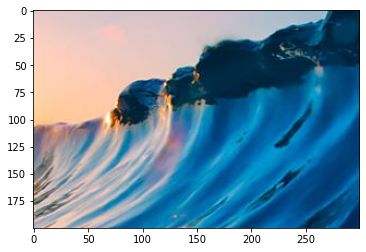

In [5]:
I1 = plt.imread('../data/ocean.jpg')
Xtrue = I1[200:400, 450:750, :]/255
plt.imshow(Xtrue)

In [6]:
nbPixel = Xtrue.shape[0]*Xtrue.shape[1]

In [7]:
r = np.random.RandomState(10)
print(r)
nbChgm = int(nbPixel/50)
idChgmI = r.randint(Xtrue.shape[0], size=(nbChgm,)) #1000 nombres aléatoires entre 0 et X1.shape --> 72000
idChgmJ = r.randint(Xtrue.shape[1], size=(nbChgm,)) #1000 nombres aléatoires entre 0 et X1.shape --> 72000

RandomState(MT19937)


In [8]:
Xtrue_delayed = np.copy(Xtrue)
for i in range(nbChgm):
    change = r.rand(3,3)
    idI = idChgmI[i]
    idJ = idChgmJ[i]
    if(idI >= 2 and idJ >= 2 and idI<Xtrue_delayed.shape[0]-2 and idJ<Xtrue_delayed.shape[1]-2):
        for j in range(Xtrue_delayed.shape[2]):
            Xtrue_delayed[idI-1:idI+2,idJ-1:idJ+2,j] = change

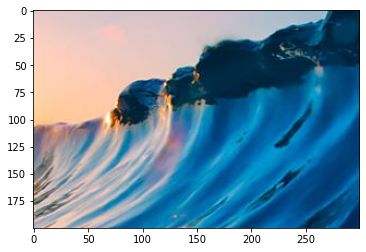

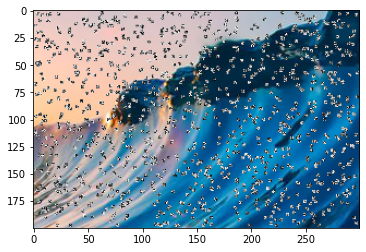

In [9]:
plt.figure()
plt.imshow(Xtrue)
plt.figure()
plt.imshow(Xtrue_delayed)

In [10]:
DeltaX_true = np.abs(Xtrue_delayed-Xtrue)

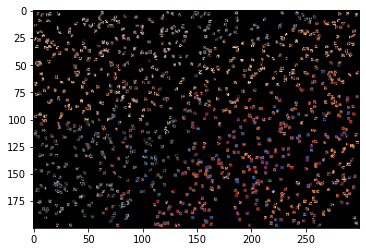

In [11]:
plt.imshow(DeltaX_true)

In [12]:
L_H = spatial_degradation(Xtrue, 2, 0)
L_M = spectrale_degradation(Xtrue_delayed, 1, 3, 0)

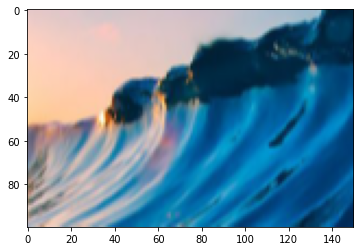

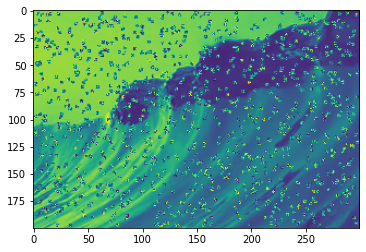

In [13]:
plt.figure()
plt.imshow(L_H)
plt.figure()
plt.imshow(L_M)

# Algo de descente proximal

Le problème de minimisation est :
\begin{equation*}
\min_{X, \Delta X} SW(L_H, X) + SW(L_M, X+\Delta X) + \lambda ||X - \bar{X}||^2 + \mu ||\Delta X||^2
\end{equation*}

In [14]:
def Fonctionnelle_detection(X, Delta_X, L_H, L_M, K_ech, b_low, b_high, Lbd, mu, Teta_H, Teta_M):
    SW1, Gradient1 = SW_gradSW(spatial_degradation(X,K_ech, 0), L_H, Teta_H)
    SW2, Gradient2 = SW_gradSW(spectrale_degradation(X+Delta_X, b_low, b_high, 0), L_M, Teta_M)
    
    L2 = np.linalg.norm(X-reech_interp(L_H, K_ech))**2
    
    L2Delta = np.linalg.norm(Delta_X)**2
    
    Fct = 10*SW1 + SW2 + Lbd*L2 + mu*L2Delta
    
    return Fct

Algorithme PALM (Proximal alternating) :

Le problème se traduit par :
\begin{equation*}
\min_{X, \Delta X} f(X) + g(\Delta X) + H(X, \Delta X)
\end{equation*}

Avec $f(X) = \lambda ||X - \bar{X}||^2$

$g(\Delta X) = \mu ||\Delta X||^2 $

$H(X, \Delta X) = SW(L_H, X) + SW(L_M, X+\Delta X)$


À chaque itération de l'algo : 
\begin{equation*}
X^{k+1} \in prox^f_{c_k}(X^k - \frac{1}{c_k}\nabla_X H(X^k, \Delta X^k))
\end{equation*}

et

\begin{equation*}
\Delta X^{k+1} \in prox^g_{d_k}(\Delta X^k - \frac{1}{d_k}\nabla_{\Delta X} H(X^{k+1}, \Delta X^k))
\end{equation*}




Les deux fonctions suivantes sont pour résoudre ces calculs de prox par descente de gradient (calcul de argmin)

In [15]:
def resProx1(X, Delta_X, L_H, L_M, K_ech, b_low, b_high, Lbd, gamma1, Teta_H, Teta_M):
    SW1, Gradient1 = SW_gradSW(spatial_degradation(X,K_ech, 0), L_H, Teta_H)
    SW2, Gradient2 = SW_gradSW(spectrale_degradation(X, b_low, b_high, 0), L_M - spectrale_degradation(Delta_X, b_low, b_high, 0), Teta_M)
    
    ck = gamma1
    cste = X - (1/ck)*(spatial_degradation(Gradient1, K_ech, 1) + spectrale_degradation(Gradient2, b_low, b_high, 1))
    Xbarre = reech_interp(L_H, K_ech)
    pas = 0.1
    
    U = Xbarre
    
    Fct = [Lbd*np.linalg.norm(U-Xbarre)**2 + (ck/2)*np.linalg.norm(U - cste)**2]
    
    grad = 2*Lbd*(U-Xbarre) + ck*(U - cste)
    U = U - grad*pas
    
    Fct.append(Lbd*np.linalg.norm(U-Xbarre)**2 + (ck/2)*np.linalg.norm(U - cste)**2)
    
    i = 1
    
    while(np.abs(Fct[i]-Fct[i-1])**2/np.abs(Fct[i-1])**2 > 10**-6 and i <100):
        grad = 2*Lbd*(U-Xbarre) + ck*(U - cste)
        U = U - grad*pas
        
        Fct.append(Lbd*np.linalg.norm(U-Xbarre)**2 + (ck/2)*np.linalg.norm(U - cste)**2)
        
        print( 'iter = ', i ,  "fonction = ", Fct[i])
        
        i = i+1
    
    return U, Fct
    
    
    

def resProx2(X, Delta_X, L_H, L_M, K_ech, b_low, b_high, mu, gamma2, Teta_M):
    SW2, Gradient2 = SW_gradSW(spectrale_degradation(X + Delta_X, b_low, b_high, 0), L_M, Teta_M)
    
    dk = gamma2
    cste = Delta_X - (1/dk)*spectrale_degradation(Gradient2, b_low, b_high, 1)
    pas = 0.1
    
    U = np.zeros(X.shape)
    Fct = [mu*np.linalg.norm(U)**2 + (dk/2)*np.linalg.norm(U-cste)**2]
    
    grad = 2*mu*U + dk*(U - cste)
    U = U - grad*pas
    
    Fct.append(mu*np.linalg.norm(U)**2 + (dk/2)*np.linalg.norm(U-cste)**2)
    
    i = 1
    
    while(np.abs(Fct[i]-Fct[i-1])**2/np.abs(Fct[i-1])**2 > 10**-6 and i <100):
        grad = 2*mu*U + dk*(U - cste)
        U = U - grad*pas

        Fct.append(mu*np.linalg.norm(U)**2 + (dk/2)*np.linalg.norm(U-cste)**2)
    
        print( 'iter = ', i ,  "fonction = ", Fct[i])
        
        i = i+1
    
    return U, Fct


In [16]:
d_H = L_H.shape[2]
random_state = np.random.RandomState(None)
Teta_H = random_state.normal(0., 1., [10, d_H])
norm_H = np.linalg.norm(Teta_H, ord=2, axis=1, keepdims=True)
Teta_H = Teta_H / norm_H

d_M = L_M.shape[2]
random_state = np.random.RandomState(None)
Teta_M = random_state.normal(0., 1., [10, d_M])
norm_M = np.linalg.norm(Teta_M, ord=2, axis=1, keepdims=True)
Teta_M = Teta_M / norm_M


In [17]:
res, fct = resProx1(Xtrue, DeltaX_true, L_H, L_M, 2, 1, 3, 1, 0.1, Teta_H, Teta_M)

iter =  1 fonction =  105102.46578400658
iter =  2 fonction =  103906.92496816827
iter =  3 fonction =  103160.78794500361
iter =  4 fonction =  102695.12382884658
iter =  5 fonction =  102404.50285395289
iter =  6 fonction =  102223.12630352179
iter =  7 fonction =  102109.92919839776


Calculs exact des prox :

prox it 1 : $prox^f{x} = (2\lambda Id + Id)^{-1}(x+2\bar{X}) = (2\lambda +1)(x+2\bar{X})$

et 

prox it 2 : $prox^g{x} = (2\mu Id + Id)^{-1}x = (2\mu + 1)x$

In [32]:
def prox1(X, Xbarre, Lbd):
    return (1/(2*Lbd+1))*(X + 2*Xbarre)
    
def prox2(X, mu):
    return (1/(2*mu +1))*X

In [33]:
def descente_detection(L_H, L_M, K_ech, b_low, b_high, Lbd, mu, gamma1, gamma2, nbProj):
    X = reech_interp(L_H, K_ech)
    Delta_X = np.zeros(X.shape)
    
    Xbarre = reech_interp(L_H, K_ech)
    
    ck = 1/gamma1
    dk = 1/gamma2
    
    d_H = L_H.shape[2]
    random_state = np.random.RandomState(None)
    Teta_H = random_state.normal(0., 1., [nbProj, d_H])
    norm_H = np.linalg.norm(Teta_H, ord=2, axis=1, keepdims=True)
    Teta_H = Teta_H / norm_H
    
    d_M = L_M.shape[2]
    random_state = np.random.RandomState(None)
    Teta_M = random_state.normal(0., 1., [nbProj, d_M])
    norm_M = np.linalg.norm(Teta_M, ord=2, axis=1, keepdims=True)
    Teta_M = Teta_M / norm_M

    Fct = [Fonctionnelle_detection(X, Delta_X, L_H, L_M, K_ech, b_low, b_high, Lbd, mu, Teta_H, Teta_M)]

    # Calcul première it de prox
    SW1, Gradient1 = SW_gradSW(spatial_degradation(X,K_ech, 0), L_H, Teta_H)
    SW2, Gradient2 = SW_gradSW(spectrale_degradation(X, b_low, b_high, 0), L_M - spectrale_degradation(Delta_X, b_low, b_high, 0), Teta_M)
    
    descente_X = X - (1/ck)*(spatial_degradation(Gradient1, K_ech, 1) + spectrale_degradation(Gradient2, b_low, b_high, 1))
    X = prox1(descente_X, Xbarre, Lbd)
    #X = descente_X
    # Calcul deuxième it de prox
    SW2, Gradient2 = SW_gradSW(spectrale_degradation(X + Delta_X, b_low, b_high, 0), L_M, Teta_M)
    
    descente_DeltaX = Delta_X - (1/dk)*spectrale_degradation(Gradient2, b_low, b_high, 1)
    
    Delta_X = prox2(descente_DeltaX, mu)
    #Delta_X = descente_DeltaX
    Fct.append(Fonctionnelle_detection(X, Delta_X, L_H, L_M, K_ech, b_low, b_high, Lbd, mu, Teta_H, Teta_M))
    
    i = 1
    
    while(np.abs(Fct[i]-Fct[i-1])**2/np.abs(Fct[i-1])**2 > 10**-8 and i <100):
        # Calcul première it de prox
        SW1, Gradient1 = SW_gradSW(spatial_degradation(X,K_ech, 0), L_H, Teta_H)
        SW2, Gradient2 = SW_gradSW(spectrale_degradation(X, b_low, b_high, 0), L_M - spectrale_degradation(Delta_X, b_low, b_high, 0), Teta_M)

        descente_X = X - (1/ck)*(spatial_degradation(Gradient1, K_ech, 1) + spectrale_degradation(Gradient2, b_low, b_high, 1))
        X = prox1(descente_X, Xbarre, Lbd)
        #X = descente_X
        # Calcul deuxième it de prox
        SW2, Gradient2 = SW_gradSW(spectrale_degradation(X + Delta_X, b_low, b_high, 0), L_M, Teta_M)

        descente_DeltaX = Delta_X - (1/dk)*spectrale_degradation(Gradient2, b_low, b_high, 1)

        Delta_X = prox2(descente_DeltaX, mu)
        #Delta_X = descente_DeltaX
        Fct.append(Fonctionnelle_detection(X, Delta_X, L_H, L_M, K_ech, b_low, b_high, Lbd, mu, Teta_H, Teta_M))
        
        print( 'iter = ', i ,  "fonction = ", Fct[i])
        
        i = i+1
        
    return X, Delta_X, Fct


In [34]:
X, Delta_X, Fct = descente_detection(L_H, L_M, 2, 1, 3, 1, 1, 0.001, 0.001, 10)

iter =  1 fonction =  21.56985480675051
iter =  2 fonction =  21.537701196615455
iter =  3 fonction =  21.527049176500075
iter =  4 fonction =  21.523517126179016


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


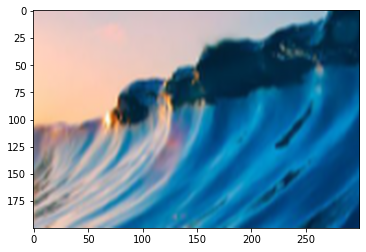

In [35]:
plt.imshow(X)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


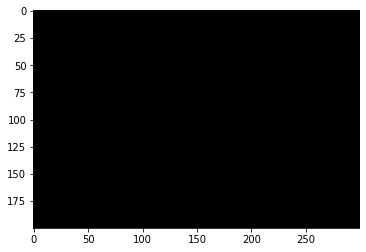

In [37]:
plt.imshow(Delta_X)

In [38]:
Delta_X

array([[[ 9.81159247e-06,  9.81159247e-06,  9.81159247e-06],
        [ 8.89584473e-06,  8.89584473e-06,  8.89584473e-06],
        [ 8.72038361e-06,  8.72038361e-06,  8.72038361e-06],
        ...,
        [-1.69937247e-05, -1.69937247e-05, -1.69937247e-05],
        [-1.28287596e-05, -1.28287596e-05, -1.28287596e-05],
        [-1.11000852e-05, -1.11000852e-05, -1.11000852e-05]],

       [[ 9.78918712e-06,  9.78918712e-06,  9.78918712e-06],
        [ 8.88462925e-06,  8.88462925e-06,  8.88462925e-06],
        [ 8.70282511e-06,  8.70282511e-06,  8.70282511e-06],
        ...,
        [-1.63617790e-05, -1.63617790e-05, -1.63617790e-05],
        [-1.39077058e-05, -1.39077058e-05, -1.39077058e-05],
        [-1.20101310e-05, -1.20101310e-05, -1.20101310e-05]],

       [[ 9.56669477e-06,  9.56669477e-06,  9.56669477e-06],
        [ 8.68123571e-06,  8.68123571e-06,  8.68123571e-06],
        [ 8.47643733e-06,  8.47643733e-06,  8.47643733e-06],
        ...,
        [-1.48907199e-05, -1.48907199e-05,